In [1]:
import pandas as pd

# Read data
train = pd.read_csv('dengue_features_train.csv')
test = pd.read_csv('dengue_features_test.csv')
labels = pd.read_csv('dengue_labels_train.csv')

# *Cleaning data*

In [2]:
# Convert week_start_date to datetime object
train['week_start_date'] = pd.to_datetime(train['week_start_date'])

In [3]:
# Putting week_start_date to become index
train.index = train['week_start_date']

In [4]:
# Splitting cities
train_sj = train[train['city'] == 'sj'].copy()
train_iq = train[train['city'] == 'iq'].copy()

In [5]:
# Merging train and labels data
train_sj = train_sj.merge(labels, on=['city', 'year', 'weekofyear'])

In [6]:
# Setting datetime index
train_sj.index = train_sj['week_start_date']

# *Imputing Nans*

In [7]:
# Only columns with missing values
nans_columns = train_sj.columns[4:]

In [8]:
# Imputing with linear interpolation
linear_sj = train_sj[nans_columns].interpolate(method='linear')

# Training the model in two parts

The data for sj city is split in two parts, values with high target value, and values with low target value. I've split them like this:
- One with a target value above 300, and another one lower than 100.

In [20]:
target = 'total_cases'

# Splitting data to high and low target values
data_high_value = linear_sj.loc[linear_sj[target] > 300].copy() # 11 rows
data_low_value = linear_sj.loc[linear_sj[target] < 100].copy() # 880 rows

In [25]:
train_data_low = data_low_value.iloc[:-100].copy()
test_data_low = data_low_value.iloc[-100:].copy()

# *Low target value*

In [11]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error

predictors = linear_sj.columns[:-1]
target = 'total_cases'

# Initializing model
svm = SVR(kernel='linear',
         C=10,
         tol=0.01,
         epsilon=0.04,
         shrinking=True)

svm.fit(train_data_low[predictors], train_data_low[target])
preds = svm.predict(test_data_low[predictors])

# Measuring mean absolute error
mean_absolute_error(test_data_low[target], preds)

11.678084266350707

With using only data with cases lower than 100, we've removed 11 rows, which in total we now have 869

# *Low target value with scaling*

In [12]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

minmax = MinMaxScaler()

steps = [('minmax', minmax),('estimator', svm)]
pipeline = Pipeline(steps=steps)

pipeline.fit(train_data_low[predictors], train_data_low[target])
preds = pipeline.predict(test_data_low[predictors])
mean_absolute_error(test_data_low[target], preds)

10.924578645305846

# *Diagnostics*

In [13]:
# Concatenating actual values and predictions
combined = pd.concat([test_data_low[target], pd.Series(preds, index=test_data_low.index)], axis=1)
combined.columns = ['actual', 'predictions']
combined

,actual,predictions
week_start_date,,
2006-04-16,3,11.770854
2006-04-23,3,7.916063
2006-04-30,3,12.319342
2006-05-07,7,13.232779
2006-05-14,3,10.614792
...,...,...
2008-03-25,4,4.008550
2008-04-01,3,9.298763
2008-04-08,1,11.871967


Most definitely we are getting higher predictions thanks to outliers.

                 actual  predictions
week_start_date                     
2006-04-16            3    11.770854
2006-04-23            3     7.916063
2006-04-30            3    12.319342
2006-05-07            7    13.232779
2006-05-14            3    10.614792
...                 ...          ...
2008-03-25            4     4.008550
2008-04-01            3     9.298763
2008-04-08            1    11.871967
2008-04-15            3     6.228333
2008-04-22            5     5.057616

[100 rows x 2 columns]


<AxesSubplot:>

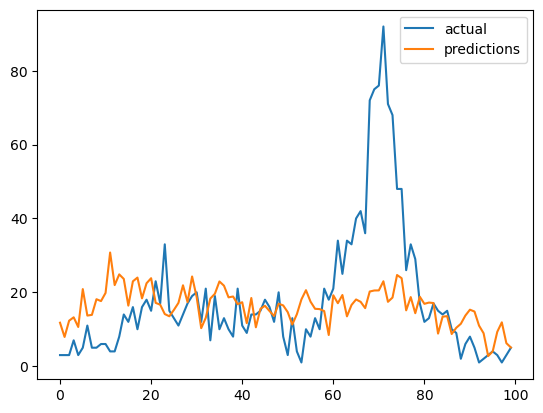

In [21]:
# Concatenating actual values and predictions
combined = pd.concat([test_data_low[target], pd.Series(preds, index=test_data_low.index)], axis=1)
combined.columns = ['actual', 'predictions']
print(combined)

# Plotting actual vs predictions
combined.reset_index().drop(columns=['week_start_date']).plot()

# *Removing outliers by formula*
https://www.askpython.com/python/examples/detection-removal-outliers-in-python

In [15]:
import numpy as np

for x in ['total_cases']:
    q75, q25 = np.percentile(linear_sj.loc[:,x].copy(), [75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    linear_sj.loc[linear_sj[x] < min,x] = np.nan
    linear_sj.loc[linear_sj[x] > max,x] = np.nan

In [16]:
linear_sj.dropna(subset=['total_cases'], inplace=True)

In [26]:
# Splitting train and test data
train_data_outliers = linear_sj.iloc[:-100].copy()
test_data_outliers = linear_sj.iloc[-100:].copy()

# Pipeline
pipeline = Pipeline(steps=steps)
pipeline.fit(train_data_outliers[predictors], train_data_outliers[target])
preds = pipeline.predict(test_data_outliers[predictors])
mean_absolute_error(test_data_outliers[target], preds)

10.504656426340668